In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
from pandas import read_csv, unique

import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow import stack
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation
from tensorflow.keras.layers import Conv1D, Flatten, Reshape, MaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

In [3]:
names = ["NaN", "user_id", "activity", "timestamp", "x_axis", "y_axis", "z_axis"]
data = pd.read_csv("C:/Users/GACHON/Desktop/AiStudy/data/WISDM.csv", header=None, names=names, skiprows=1)

def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

df = data.drop('NaN', axis=1)
df["z_axis"] = df["z_axis"].replace(regex=True, to_replace=r';', value=r'')
    # ... and then this column must be transformed to float explicitly
df.dropna(axis=0, how='any', inplace=True)
df.head()
print(df.shape)

(1098203, 6)


In [4]:
df.head()

,user_id,activity,timestamp,x_axis,y_axis,z_axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1098203 entries, 0 to 1098202
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user_id    1098203 non-null  int64  
 1   activity   1098203 non-null  object 
 2   timestamp  1098203 non-null  int64  
 3   x_axis     1098203 non-null  float64
 4   y_axis     1098203 non-null  float64
 5   z_axis     1098203 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 50.3+ MB


In [6]:
df = df[~df['activity'].str.contains('Jogging|Sitting|Upstairs|Downstairs')]

In [7]:
print(df['activity'].value_counts())

activity
Walking     424397
Standing     48395
Name: count, dtype: int64


In [8]:
mapping = {'Walking': 0, 'Standing': 1}

# 레이블 인코딩
df['ActivityEncoded'] = df['activity'].map(mapping)
df

,user_id,activity,timestamp,x_axis,y_axis,z_axis,ActivityEncoded
597,33,Walking,49394992294000,0.844462,8.008764,2.792171,0
598,33,Walking,49395102310000,1.116869,8.621680,3.786457,0
599,33,Walking,49395202316000,-0.503953,16.657684,1.307553,0
600,33,Walking,49395302292000,4.794363,10.760075,-1.184970,0
601,33,Walking,49395412338000,-0.040861,9.234595,-0.694638,0
...,...,...,...,...,...,...,...
1095664,19,Standing,131477821443000,-4.990000,8.390000,-0.380000,1
1095665,19,Standing,131477861513000,-5.130000,8.240000,-0.420000,1
1095666,19,Standing,131477941499000,-4.560000,8.500000,-0.890000,1
1095667,19,Standing,131477981508000,-4.480000,8.540000,-1.080000,1


In [9]:
df.shape

(472792, 7)

C:\Users\GACHON\anaconda3\envs\test01\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\GACHON\anaconda3\envs\test01\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


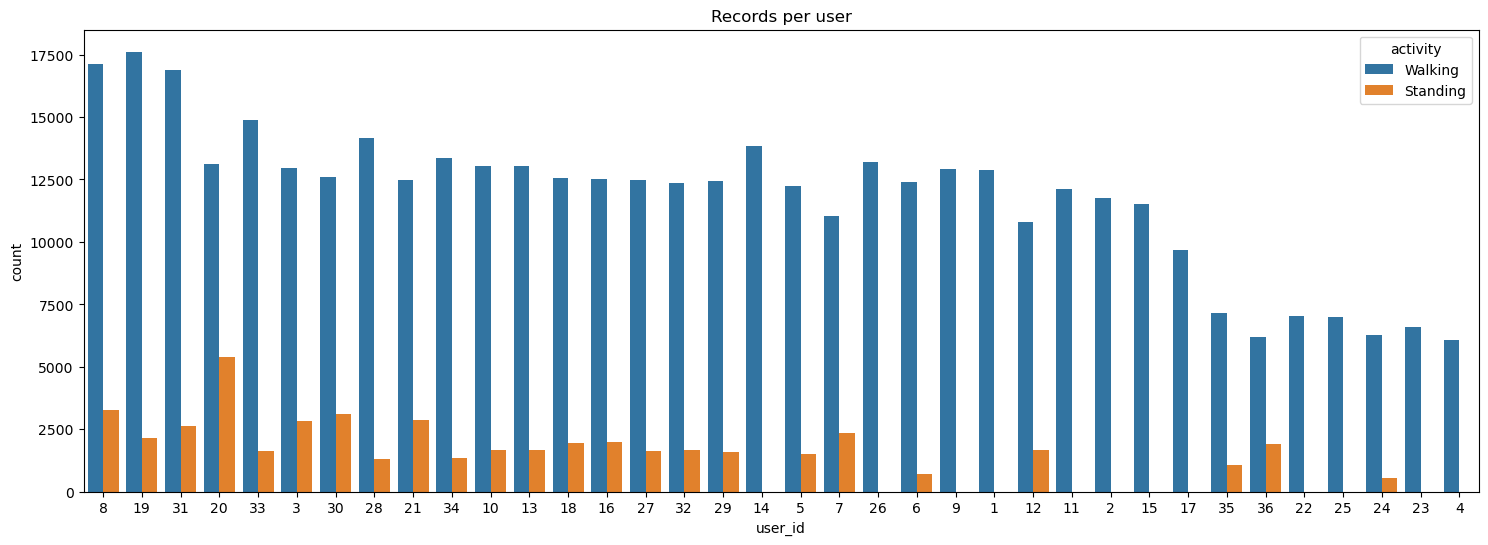

In [10]:
plt.figure(figsize=(18, 6))
sns.countplot(x = "user_id", hue="activity", data = df,
              order = df.user_id.value_counts().index)
plt.title("Records per user");

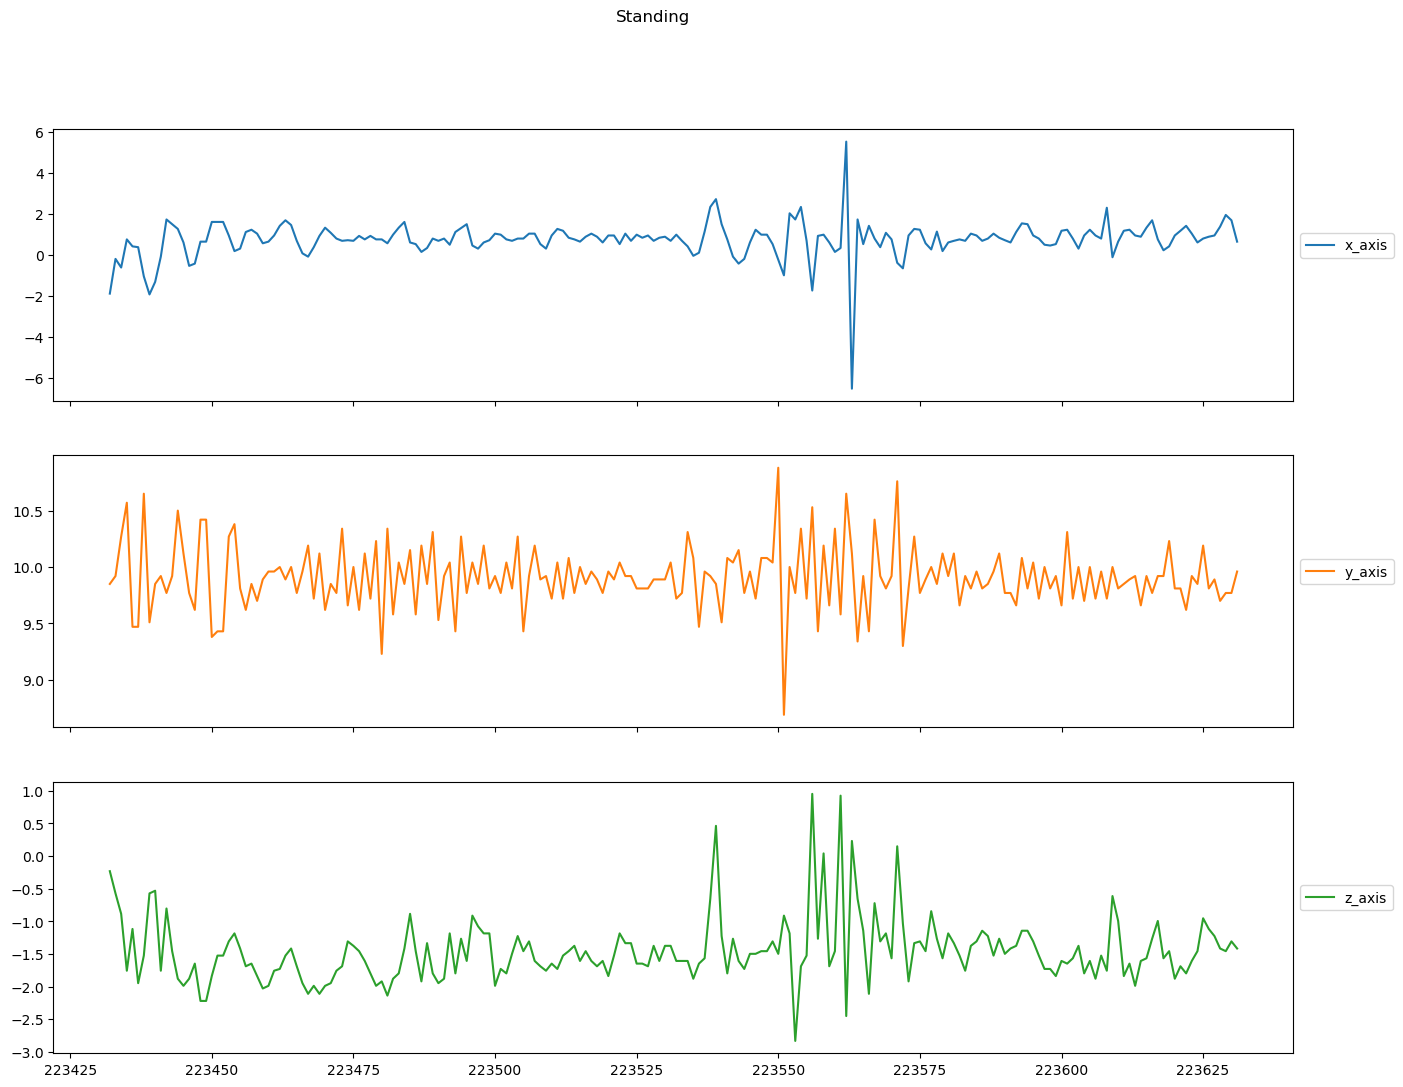

In [11]:
def plot_activity(activity, df):
    data = df[df["activity"] == activity][["x_axis", "y_axis", "z_axis"]][:200]
    axis = data.plot(subplots = True, figsize = (16, 12), title = activity)
    for ax in axis:
        ax.legend(loc = "lower left", bbox_to_anchor = (1.0, 0.5))

plot_activity("Standing", df)

In [12]:
X = df[["x_axis", "y_axis", "z_axis"]].values  # 변경
y = df['ActivityEncoded'].values.reshape(-1, 1)  # 변경

In [13]:
X_train, X_test,y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify= y)
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size = 0.2, stratify= y_train )
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(302586, 3) (302586, 1)
(94559, 3) (94559, 1)


In [14]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
enc.fit(y_train)

y_train_hot = enc.transform(y_train) 
y_test_hot = enc.transform(y_test) 
y_val_hot = enc.transform(y_val)

In [15]:
n_features, n_outputs = X_train.shape[1], y_train_hot.shape[1]

<h1>Epoch 10 (Data Balancing X)</h1>

In [16]:
model = keras.Sequential()
model.add(keras.layers.Dense(50, activation='relu', input_shape=(n_features,)))
model.add(Flatten())
model.add(Dense(n_outputs, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                200       
                                                                 
 flatten (Flatten)           (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 102       
                                                                 
Total params: 302
Trainable params: 302
Non-trainable params: 0
_________________________________________________________________


In [17]:
epochs, batch_size = 10, 128
history = model.fit(X_train, y_train_hot, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_val, y_val_hot), shuffle=True)

Epoch 1/10
2364/2364 [==============================] - 6s 2ms/step - loss: 0.2515 - accuracy: 0.8960 - val_loss: 0.2169 - val_accuracy: 0.8976
Epoch 2/10
2364/2364 [==============================] - 6s 2ms/step - loss: 0.1955 - accuracy: 0.9105 - val_loss: 0.1786 - val_accuracy: 0.9261
Epoch 3/10
2364/2364 [==============================] - 6s 3ms/step - loss: 0.1706 - accuracy: 0.9305 - val_loss: 0.1646 - val_accuracy: 0.9237
Epoch 4/10
2364/2364 [==============================] - 6s 3ms/step - loss: 0.1546 - accuracy: 0.9403 - val_loss: 0.1451 - val_accuracy: 0.9465
Epoch 5/10
2364/2364 [==============================] - 6s 3ms/step - loss: 0.1407 - accuracy: 0.9451 - val_loss: 0.1349 - val_accuracy: 0.9477
Epoch 6/10
2364/2364 [==============================] - 6s 3ms/step - loss: 0.1300 - accuracy: 0.9482 - val_loss: 0.1267 - val_accuracy: 0.9444
Epoch 7/10
2364/2364 [==============================] - 6s 3ms/step - loss: 0.1224 - accuracy: 0.9503 - val_loss: 0.1184 - val_accuracy:

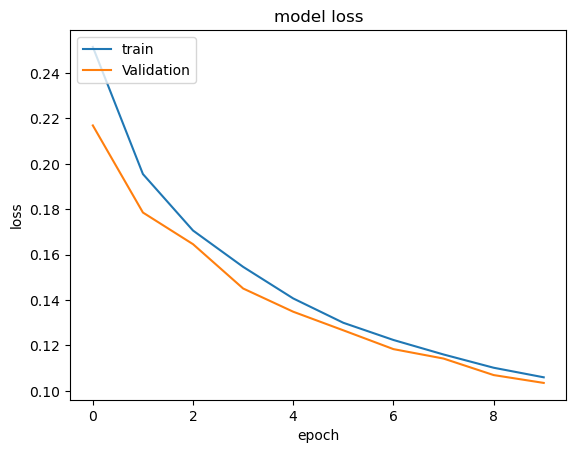

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

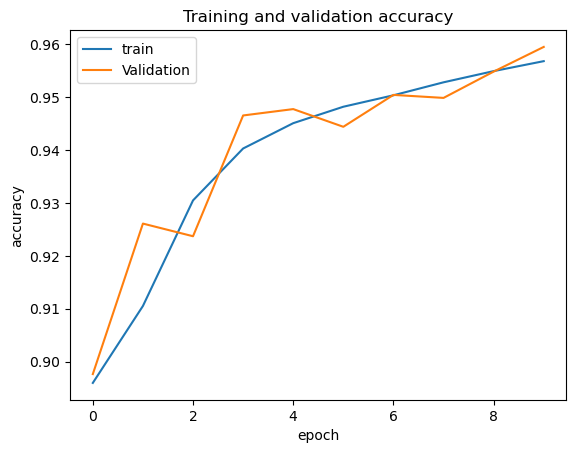

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

2955/2955 [==============================] - 2s 553us/step
f1_score =  0.958663716913606
0.9579204517814275
              precision    recall  f1-score   support

           0       0.98      0.97      0.98     84880
           1       0.77      0.84      0.80      9679

    accuracy                           0.96     94559
   macro avg       0.88      0.90      0.89     94559
weighted avg       0.96      0.96      0.96     94559



<Axes: >

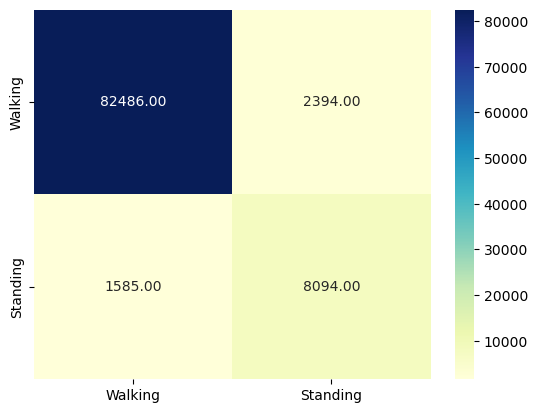

In [20]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking','Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_true, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1>Epoch 20 (Data Balancing X)</h1>

In [21]:
model = keras.Sequential()
model.add(keras.layers.Dense(50, activation='relu', input_shape=(n_features,)))
model.add(Flatten())
model.add(Dense(n_outputs, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 50)                200       
                                                                 
 flatten_1 (Flatten)         (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 2)                 102       
                                                                 
Total params: 302
Trainable params: 302
Non-trainable params: 0
_________________________________________________________________


In [22]:
epochs, batch_size = 10, 128
history = model.fit(X_train, y_train_hot, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_val, y_val_hot), shuffle=True)

Epoch 1/10
2364/2364 [==============================] - 7s 3ms/step - loss: 0.2490 - accuracy: 0.8972 - val_loss: 0.2225 - val_accuracy: 0.8982
Epoch 2/10
2364/2364 [==============================] - 7s 3ms/step - loss: 0.1936 - accuracy: 0.9117 - val_loss: 0.1701 - val_accuracy: 0.9360
Epoch 3/10
2364/2364 [==============================] - 7s 3ms/step - loss: 0.1581 - accuracy: 0.9405 - val_loss: 0.1458 - val_accuracy: 0.9428
Epoch 4/10
2364/2364 [==============================] - 7s 3ms/step - loss: 0.1390 - accuracy: 0.9468 - val_loss: 0.1303 - val_accuracy: 0.9481
Epoch 5/10
2364/2364 [==============================] - 7s 3ms/step - loss: 0.1269 - accuracy: 0.9491 - val_loss: 0.1212 - val_accuracy: 0.9487
Epoch 6/10
2364/2364 [==============================] - 7s 3ms/step - loss: 0.1185 - accuracy: 0.9521 - val_loss: 0.1139 - val_accuracy: 0.9555
Epoch 7/10
2364/2364 [==============================] - 7s 3ms/step - loss: 0.1125 - accuracy: 0.9544 - val_loss: 0.1093 - val_accuracy:

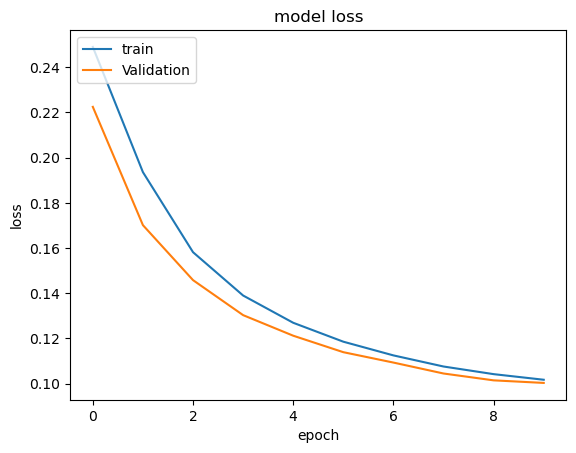

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

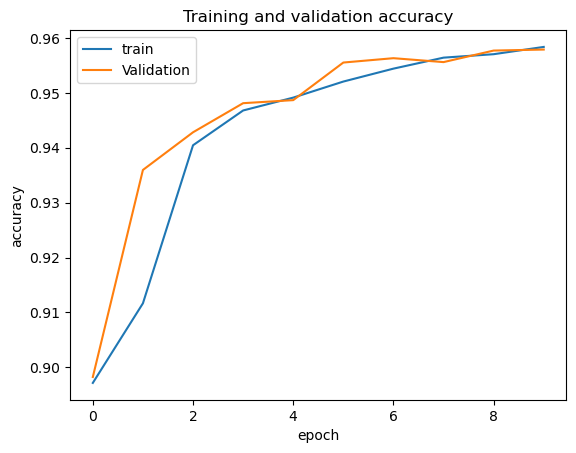

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

2955/2955 [==============================] - 2s 563us/step
f1_score =  0.9585200463230423
0.9583540435072283
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     84880
           1       0.79      0.81      0.80      9679

    accuracy                           0.96     94559
   macro avg       0.88      0.89      0.89     94559
weighted avg       0.96      0.96      0.96     94559



<Axes: >

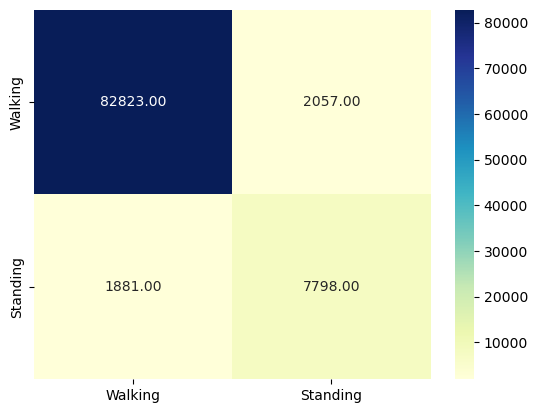

In [25]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking','Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_true, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1>Data Balacing</h1>

In [26]:
#Smote()를 통한 OverSampling
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(df.drop('activity', axis=1), df['activity'])

In [27]:
df = pd.concat([pd.DataFrame(X_resampled, columns=df.drop('activity', axis=1).columns),
                         pd.DataFrame({'activity': y_resampled})], axis=1)

In [28]:
print(df['activity'].value_counts())

activity
Walking     424397
Standing    424397
Name: count, dtype: int64


In [29]:
df.head()

,user_id,timestamp,x_axis,y_axis,z_axis,ActivityEncoded,activity
0,33,49394992294000,0.844462,8.008764,2.792171,0,Walking
1,33,49395102310000,1.116869,8.621680,3.786457,0,Walking
2,33,49395202316000,-0.503953,16.657684,1.307553,0,Walking
3,33,49395302292000,4.794363,10.760075,-1.184970,0,Walking
4,33,49395412338000,-0.040861,9.234595,-0.694638,0,Walking


In [30]:
df.shape

(848794, 7)

C:\Users\GACHON\anaconda3\envs\test01\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\GACHON\anaconda3\envs\test01\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


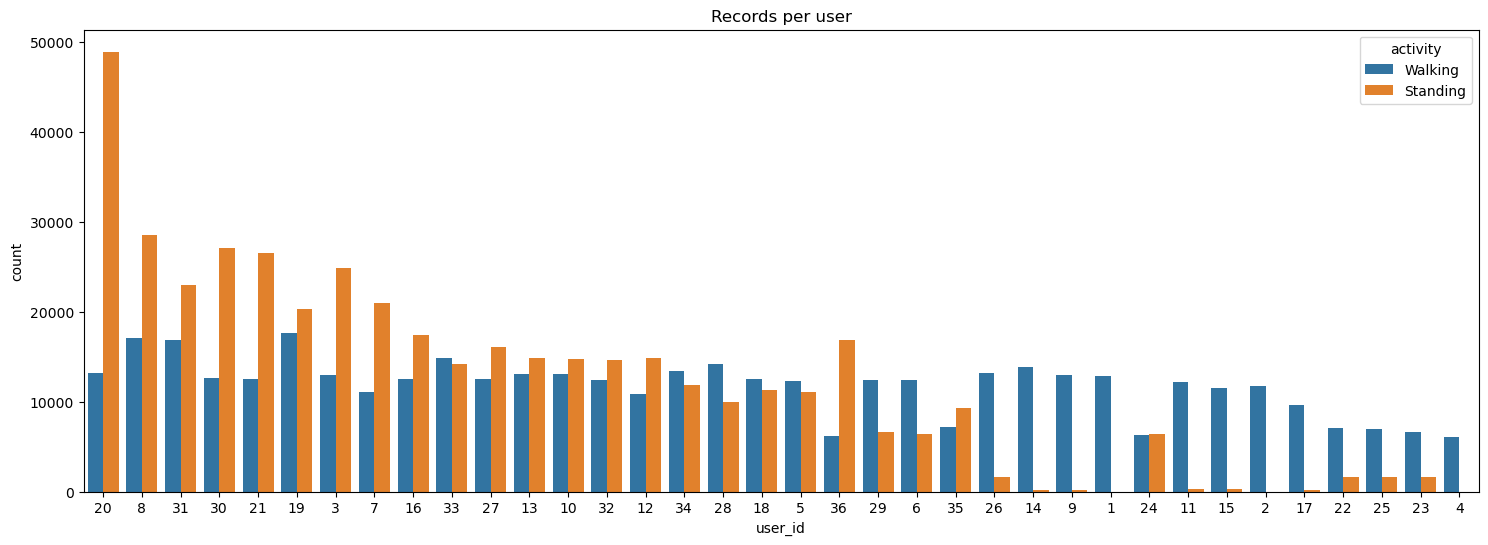

In [31]:
plt.figure(figsize=(18, 6))
sns.countplot(x = "user_id", hue="activity", data = df,
              order = df.user_id.value_counts().index)
plt.title("Records per user");

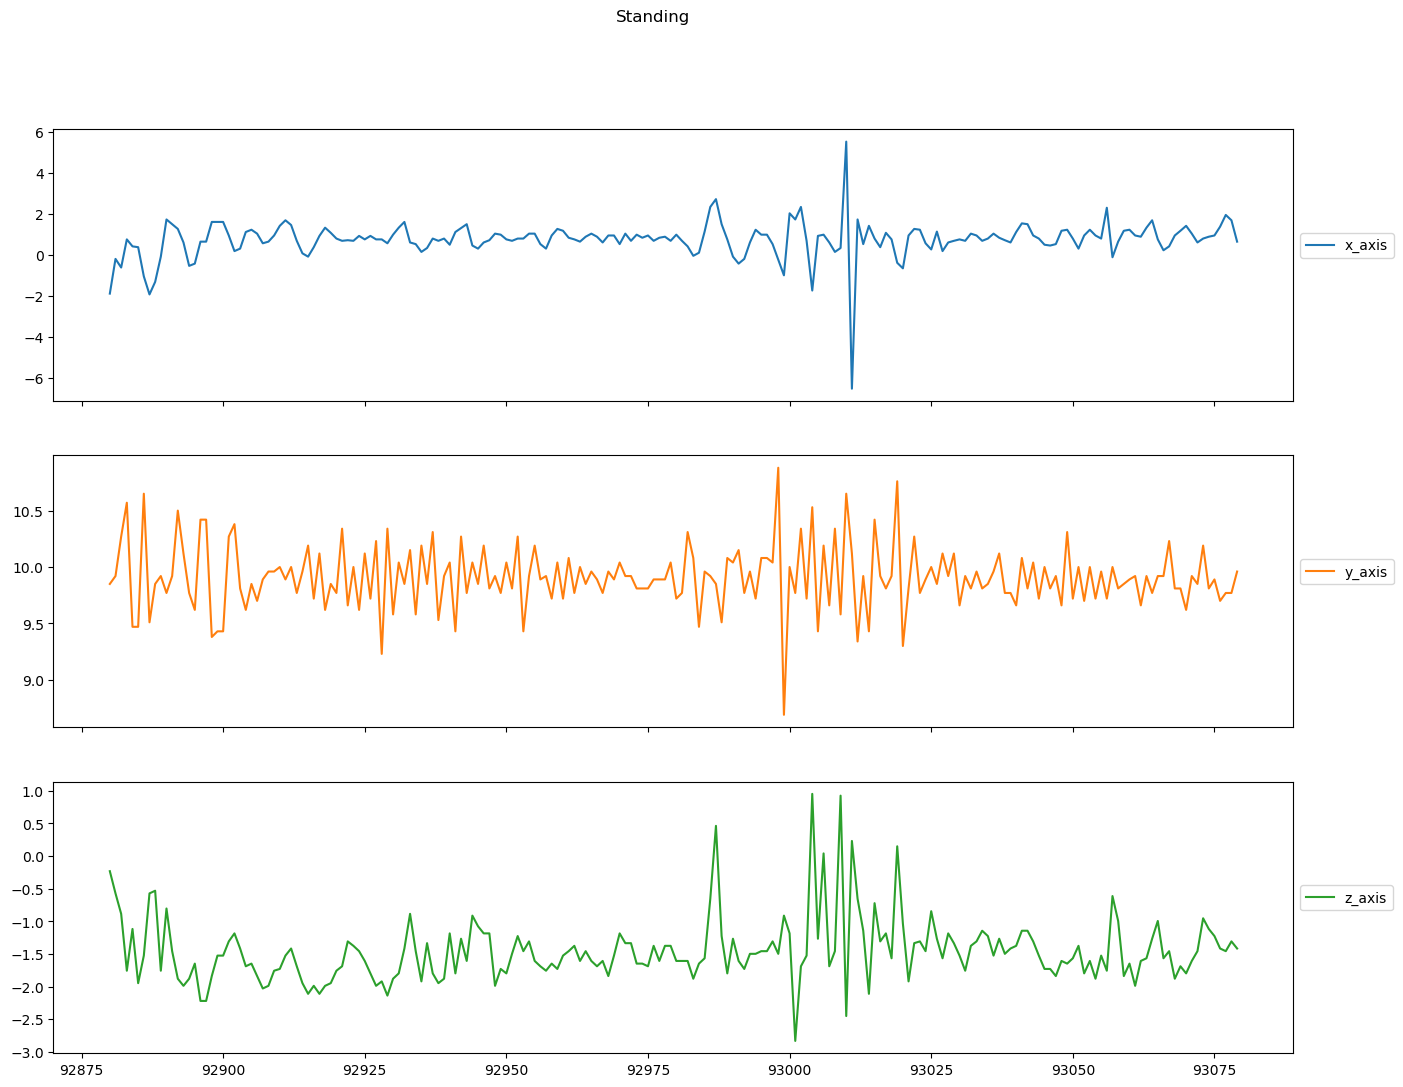

In [32]:
def plot_activity(activity, df):
    data = df[df["activity"] == activity][["x_axis", "y_axis", "z_axis"]][:200]
    axis = data.plot(subplots = True, figsize = (16, 12), title = activity)
    for ax in axis:
        ax.legend(loc = "lower left", bbox_to_anchor = (1.0, 0.5))

plot_activity("Standing", df)

In [33]:
X = df[["x_axis", "y_axis", "z_axis"]].values
y = df['ActivityEncoded'].values.reshape(-1, 1)

In [34]:
X_train, X_test,y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify= y)
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size = 0.2, stratify= y_train )
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(543228, 3) (543228, 1)
(169759, 3) (169759, 1)


In [35]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
enc.fit(y_train)

y_train_hot = enc.transform(y_train) 
y_test_hot = enc.transform(y_test) 
y_val_hot = enc.transform(y_val)

In [36]:
n_features, n_outputs = X_train.shape[1], y_train_hot.shape[1]

<h1>Epoch 10 (Data Balancing O - OverSampling)</h1>

In [37]:
model = keras.Sequential()
model.add(keras.layers.Dense(50, activation='relu', input_shape=(n_features,)))
model.add(Flatten())
model.add(Dense(n_outputs, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 50)                200       
                                                                 
 flatten_2 (Flatten)         (None, 50)                0         
                                                                 
 dense_5 (Dense)             (None, 2)                 102       
                                                                 
Total params: 302
Trainable params: 302
Non-trainable params: 0
_________________________________________________________________


In [38]:
epochs, batch_size = 10, 128
history = model.fit(X_train, y_train_hot, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_val, y_val_hot), shuffle=True)

Epoch 1/10
4244/4244 [==============================] - 12s 3ms/step - loss: 0.3649 - accuracy: 0.8411 - val_loss: 0.2481 - val_accuracy: 0.9023
Epoch 2/10
4244/4244 [==============================] - 11s 3ms/step - loss: 0.2056 - accuracy: 0.9270 - val_loss: 0.1779 - val_accuracy: 0.9374
Epoch 3/10
4244/4244 [==============================] - 11s 3ms/step - loss: 0.1646 - accuracy: 0.9434 - val_loss: 0.1559 - val_accuracy: 0.9426
Epoch 4/10
4244/4244 [==============================] - 12s 3ms/step - loss: 0.1482 - accuracy: 0.9493 - val_loss: 0.1410 - val_accuracy: 0.9521
Epoch 5/10
4244/4244 [==============================] - 11s 3ms/step - loss: 0.1402 - accuracy: 0.9524 - val_loss: 0.1364 - val_accuracy: 0.9550
Epoch 6/10
4244/4244 [==============================] - 12s 3ms/step - loss: 0.1355 - accuracy: 0.9546 - val_loss: 0.1339 - val_accuracy: 0.9534
Epoch 7/10
4244/4244 [==============================] - 12s 3ms/step - loss: 0.1329 - accuracy: 0.9558 - val_loss: 0.1282 - val_ac

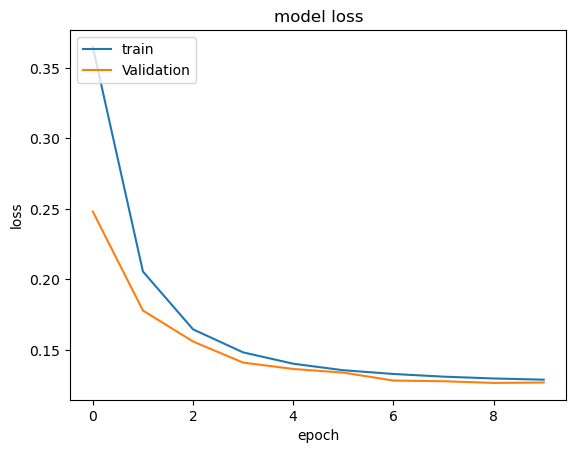

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

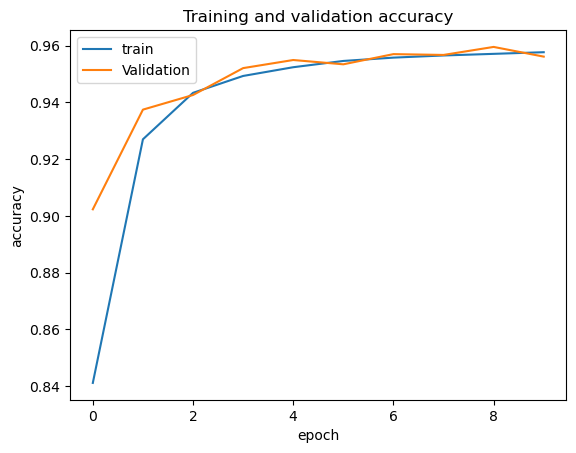

In [40]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

5305/5305 [==============================] - 3s 536us/step
f1_score =  0.9570275673541105
0.957068550121054
              precision    recall  f1-score   support

           0       0.99      0.93      0.96     84879
           1       0.93      0.99      0.96     84880

    accuracy                           0.96    169759
   macro avg       0.96      0.96      0.96    169759
weighted avg       0.96      0.96      0.96    169759



<Axes: >

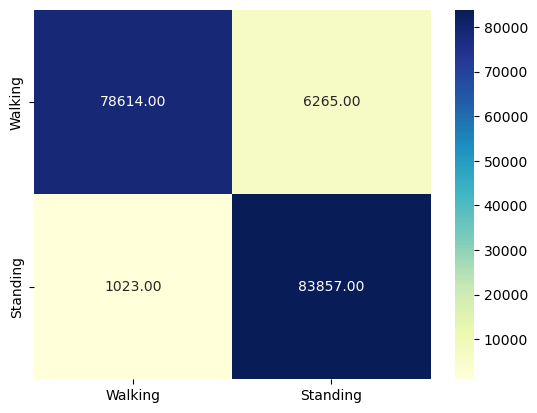

In [41]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking','Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_true, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1>Epoch 20 (Data Balancing O - OverSampling)</h1>

In [42]:
model = keras.Sequential()
model.add(keras.layers.Dense(50, activation='relu', input_shape=(n_features,)))
model.add(Flatten())
model.add(Dense(n_outputs, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 50)                200       
                                                                 
 flatten_3 (Flatten)         (None, 50)                0         
                                                                 
 dense_7 (Dense)             (None, 2)                 102       
                                                                 
Total params: 302
Trainable params: 302
Non-trainable params: 0
_________________________________________________________________


In [43]:
epochs, batch_size = 10, 128
history = model.fit(X_train, y_train_hot, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_val, y_val_hot), shuffle=True)

Epoch 1/10
4244/4244 [==============================] - 12s 3ms/step - loss: 0.3546 - accuracy: 0.8437 - val_loss: 0.2353 - val_accuracy: 0.9074
Epoch 2/10
4244/4244 [==============================] - 12s 3ms/step - loss: 0.2038 - accuracy: 0.9251 - val_loss: 0.1814 - val_accuracy: 0.9369
Epoch 3/10
4244/4244 [==============================] - 12s 3ms/step - loss: 0.1685 - accuracy: 0.9412 - val_loss: 0.1591 - val_accuracy: 0.9423
Epoch 4/10
4244/4244 [==============================] - 11s 3ms/step - loss: 0.1533 - accuracy: 0.9476 - val_loss: 0.1472 - val_accuracy: 0.9501
Epoch 5/10
4244/4244 [==============================] - 11s 3ms/step - loss: 0.1464 - accuracy: 0.9508 - val_loss: 0.1415 - val_accuracy: 0.9527
Epoch 6/10
4244/4244 [==============================] - 11s 3ms/step - loss: 0.1422 - accuracy: 0.9528 - val_loss: 0.1379 - val_accuracy: 0.9536
Epoch 7/10
4244/4244 [==============================] - 11s 3ms/step - loss: 0.1399 - accuracy: 0.9538 - val_loss: 0.1353 - val_ac

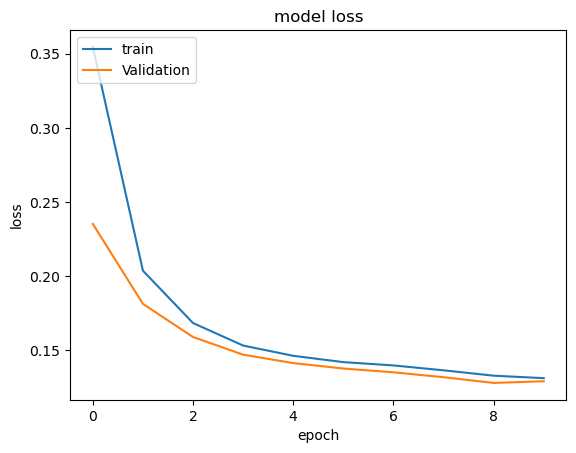

In [44]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

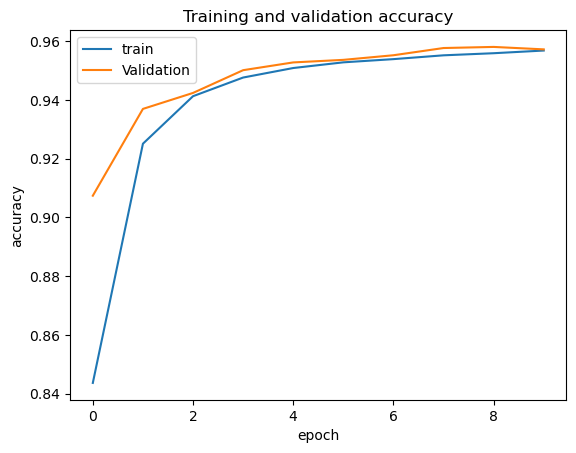

In [45]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

5305/5305 [==============================] - 3s 555us/step
f1_score =  0.9577775753945993
0.95781077880996
              precision    recall  f1-score   support

           0       0.99      0.93      0.96     84879
           1       0.93      0.99      0.96     84880

    accuracy                           0.96    169759
   macro avg       0.96      0.96      0.96    169759
weighted avg       0.96      0.96      0.96    169759



<Axes: >

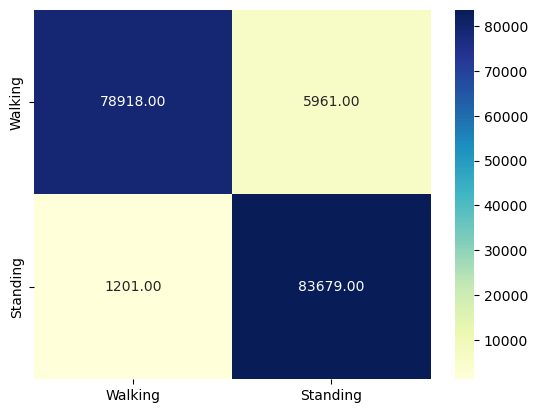

In [46]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking','Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_true, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')